# SSVQE for BODIPY (triplet states - openfermion)

MAY 2025
> **Molecule**: 4,4‑difluoro‑4‑bora‑3a,4a‑diaza‑s‑indacene (BODIPY)


### Calcul des énergies de la molecule de BODIPY

In [1]:
import os

In [2]:
# Forcer Python/NumPy/BLAS à utiliser tous les cœurs CPU disponibles
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count()-2)
os.environ["OPENBLAS_NUM_THREADS"] = str(os.cpu_count()-2)
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count()-2)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(os.cpu_count()-2)
os.environ["NUMEXPR_NUM_THREADS"] = str(os.cpu_count()-2)

print(f"🔧 Configuration parallèle : {os.cpu_count()-2} threads activés.")


🔧 Configuration parallèle : 14 threads activés.


In [3]:
# importation des packages
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import pyscf

mult (int): Spin multiplicity $\mathrm{mult}=N_\mathrm{unpaired} + 1$ for
 $N_\mathrm{unpaired}$ unpaired electrons occupying the HF orbitals.

In [4]:
# coordonnées xyz de la molecule
symbols, coordinates = qchem.read_structure('Bodipy.xyz')
molecule = qml.qchem.Molecule(
    symbols,
    coordinates,
    charge=0,
    mult=3,
    basis_name='sto-3g')
                              

In [5]:
# Hamiltonien moleculaire
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    molecule,
    mapping='jordan_wigner',
    active_electrons=4,
    active_orbitals=4,
    method="openfermion"
)
print(f'Hamiltonian built with {qubits} qubits')
#print(hamiltonian)

Hamiltonian built with 8 qubits


In [6]:
# definir l'Ansatz UCCSD
#Circuit Anstaz:
def ansatz(params, wires, s_wires, d_wires, hf_state):
    qml.UCCSD(params, wires, s_wires, d_wires, hf_state)

In [7]:
def WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=400, k=0, device_name='default.qubit'):
    """Calculates the kth excited state energy for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).
    Returns:
        => (Energy, Energies): The function returns a tuple of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)
    
    electrons = 4 #active_electrons (même nombre que plus haut)

    # Define the HF state
    hf_state = qml.qchem.hf_state(electrons, qubits)
    
    # Generate single and double excitations
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    # Define the initial values of the circuit parameters
    params = np.zeros(len(singles) + len(doubles))

    #Define the weights for the cost function.
    weights = np.random.random()

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)
    
    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires, s_wires, d_wires, hf_state)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(k+1):
        if index == k:
          cost += weights * state_cost(params, state_value=index)
        else:
          cost += state_cost(params, state_value=index)
            
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = []
    
    # Optimization loop.
    for _ in range(iterations):
      params = optimizer.step(total_cost, params)
      energy = state_cost(params, state_value=k)
      energies.append(energy)
    return energies[-1], energies

In [8]:
def WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=400, k=[0], device_name='default.qubit'):
    """Calculates the energies upto Kth excited state for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K till which the excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of List of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)
    
    electrons = 4 #active_electrons (même nombre que plus haut)

    # Define the HF state
    hf_state = qml.qchem.hf_state(electrons, qubits)
    
    # Generate single and double excitations
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    # Define the initial values of the circuit parameters
    params = np.zeros(len(singles) + len(doubles))

    #Define the weights for the cost function.
    weights = np.arange(k+1, 0, -1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires, s_wires, d_wires, hf_state)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(k+1):
          cost += weights[index] * state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((k+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params = optimizer.step(total_cost, params)
      for index in range(k+1):
        energy = state_cost(params, state_value=index)
        energies[index][itr] = energy

    # Return List
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

In [9]:
def WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=400, k=[0], device_name='default.qubit'):
    """Calculates the kth excited state energy from the list of values of k for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (List(int)): List of K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of list of Energy of Kth excited state and list of energies at each iteration for plotting the graph. 
           The list will be in the sorted order of elements in the list k.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)
    
    electrons = 4 #active_electrons (même nombre que plus haut)

    # Define the HF state
    hf_state = qml.qchem.hf_state(electrons, qubits)
    
    # Generate single and double excitations
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    # Define the initial values of the circuit parameters
    params = np.zeros(len(singles) + len(doubles))

    #Define the weights for the cost function.
    weights = np.arange(max(k)+1,0,-1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires, s_wires, d_wires, hf_state)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(max(k)+1):
          cost += weights[index] * state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((max(k)+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params = optimizer.step(total_cost, params)
      for index in range(max(k)+1):
        if index in k:
          energy = state_cost(params, state_value=index)
          energies[index][itr] = energy

    # Return List
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

Avec l'UCCSD je pense qu'on peut s'arrêter à 100 itérations

# Optimiseur Adam

In [10]:
# energies
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, stepsize=0.01, k=0)

In [11]:
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, stepsize=0.01, k=1)

In [12]:
# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, stepsize=0.01, k=1)

In [13]:
# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, stepsize=0.01, k=[0,1,2])

In [14]:
# Output:
print('Weighted SSVQE:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energy_G_1)
print('Energy of Second Excited triplet state for the Bodipy hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energies_all[0][0])
print('Energy of Second Excited triplet state for the Bodipy hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energies_custom[0][0])
print('Energy of second Excited triplet state for the Bodipy hamiltonian is:', energies_custom[1][0])

Weighted SSVQE:
Energy of First Excited triplet state for the Bodipy hamiltonian is: -589.9524016509989
Energy of Second Excited triplet state for the Bodipy hamiltonian is: -589.6113997300447

Weighted SSVQE All:
Energy of First Excited triplet state for the Bodipy hamiltonian is: -589.9617300157677
Energy of Second Excited triplet state for the Bodipy hamiltonian is: -589.8347022002413

Weighted SSVQE Custom:
Energy of First Excited triplet state for the Bodipy hamiltonian is: -589.9609893518258
Energy of second Excited triplet state for the Bodipy hamiltonian is: -589.8341578650326


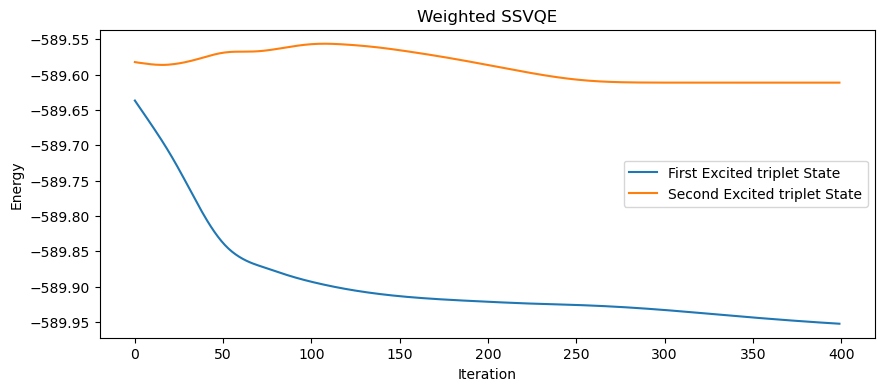

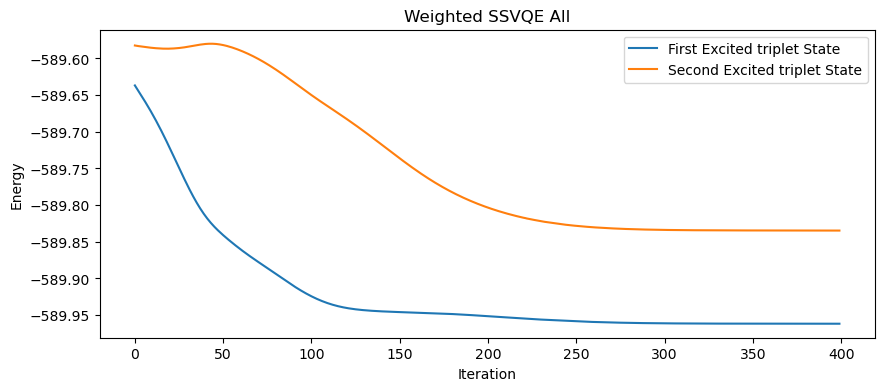

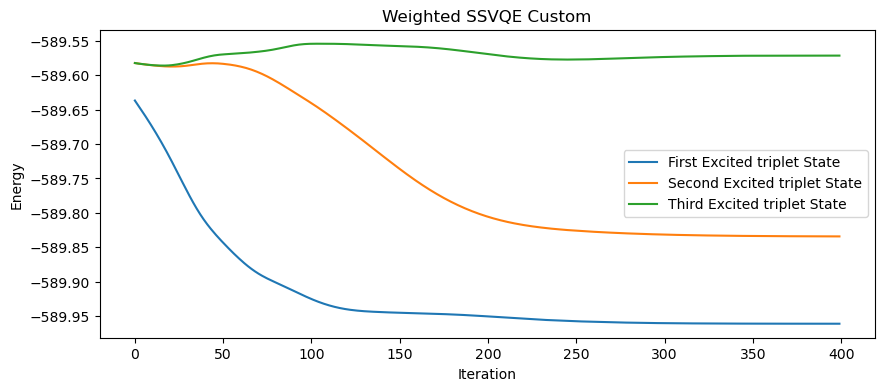

In [19]:
# Graph plot:
Iterations = [*range(0, 400)]
#Iterations2 = [*range(0, 200)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='First Excited triplet State')
plt.plot(Iterations, energies_1_1, label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='First Excited triplet State')
plt.plot(Iterations, energies_all[1][1], label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[0][1], label='First Excited triplet State')
plt.plot(Iterations, energies_custom[1][1], label='Second Excited triplet State')
plt.plot(Iterations, energies_custom[2][1], label='Third Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [16]:
#Energies d'excitation
E_S0 = -589.701986
E_T1 = energies_custom[0][0]
E_T2 = energies_custom[1][0]
E_T3 = energies_custom[2][0]

exc_T1 = (E_T1 - E_S0) * 27.2114
exc_T2 = (E_T2 - E_S0) * 27.2114

print(f"Énergie fondamentale S0 : {E_S0:.6f} Ha")
print(f"Énergie excitée T1 : {E_T1:.6f} Ha → ΔE = {exc_T1:.2f} eV")
print(f"Énergie excitée T2 : {E_T2:.6f} Ha → ΔE = {exc_T2:.2f} eV")

Énergie fondamentale S0 : -589.701986 Ha
Énergie excitée T1 : -589.960989 Ha → ΔE = -7.05 eV
Énergie excitée T2 : -589.834158 Ha → ΔE = -3.60 eV


In [18]:
E_T3

tensor(-589.57151809, requires_grad=True)

In [17]:
exc_Test = (E_T2 - E_T1) * 27.2114
print(f"Énergie excitée T2 : {E_T2:.6f} Ha → ΔE = {exc_Test:.2f} eV")

Énergie excitée T2 : -589.834158 Ha → ΔE = 3.45 eV


In [21]:
energy_G_1

tensor(-589.95240165, requires_grad=True)

In [22]:
energies_G_1

[tensor(-589.63671824, requires_grad=True),
 tensor(-589.64046709, requires_grad=True),
 tensor(-589.64405049, requires_grad=True),
 tensor(-589.64763838, requires_grad=True),
 tensor(-589.65130346, requires_grad=True),
 tensor(-589.65498336, requires_grad=True),
 tensor(-589.65863064, requires_grad=True),
 tensor(-589.66225215, requires_grad=True),
 tensor(-589.66589272, requires_grad=True),
 tensor(-589.6695801, requires_grad=True),
 tensor(-589.67330527, requires_grad=True),
 tensor(-589.67704719, requires_grad=True),
 tensor(-589.68079848, requires_grad=True),
 tensor(-589.68457269, requires_grad=True),
 tensor(-589.68839048, requires_grad=True),
 tensor(-589.69226219, requires_grad=True),
 tensor(-589.69618727, requires_grad=True),
 tensor(-589.7001644, requires_grad=True),
 tensor(-589.70419766, requires_grad=True),
 tensor(-589.70829479, requires_grad=True),
 tensor(-589.71246108, requires_grad=True),
 tensor(-589.71669605, requires_grad=True),
 tensor(-589.72099543, requires_gr

In [23]:
energy_1_1

tensor(-589.61139973, requires_grad=True)

In [24]:
energies_1_1

[tensor(-589.58232104, requires_grad=True),
 tensor(-589.58276056, requires_grad=True),
 tensor(-589.583133, requires_grad=True),
 tensor(-589.58347794, requires_grad=True),
 tensor(-589.58382993, requires_grad=True),
 tensor(-589.5841786, requires_grad=True),
 tensor(-589.58450875, requires_grad=True),
 tensor(-589.58481752, requires_grad=True),
 tensor(-589.58511256, requires_grad=True),
 tensor(-589.58539418, requires_grad=True),
 tensor(-589.58565028, requires_grad=True),
 tensor(-589.58586692, requires_grad=True),
 tensor(-589.58603789, requires_grad=True),
 tensor(-589.58616637, requires_grad=True),
 tensor(-589.58625673, requires_grad=True),
 tensor(-589.58630666, requires_grad=True),
 tensor(-589.58630856, requires_grad=True),
 tensor(-589.5862552, requires_grad=True),
 tensor(-589.58614385, requires_grad=True),
 tensor(-589.58597695, requires_grad=True),
 tensor(-589.58576023, requires_grad=True),
 tensor(-589.58550089, requires_grad=True),
 tensor(-589.58520603, requires_grad

In [25]:
energies_custom

[[tensor(-589.96098935, requires_grad=True),
  tensor([-589.63677308, -589.64055481, -589.64423473, -589.64795289,
          -589.6517949 , -589.65571678, -589.6596686 , -589.66363644,
          -589.66764184, -589.67170815, -589.67583995, -589.6800311 ,
          -589.68427803, -589.68858629, -589.69296635, -589.69742431,
          -589.70195973, -589.70657018, -589.71125542, -589.71601725,
          -589.72085504, -589.72576102, -589.73072048, -589.73571673,
          -589.74073616, -589.74576902, -589.75080613, -589.7558353 ,
          -589.76084066, -589.76580455, -589.77070941, -589.77553774,
          -589.78027168, -589.78489395, -589.78938964, -589.79374686,
          -589.79795591, -589.80200888, -589.80590079, -589.80963201,
          -589.81320951, -589.81664593, -589.81995697, -589.8231584 ,
          -589.82626365, -589.8292825 , -589.83222186, -589.83508829,
          -589.83789054, -589.84064002, -589.84334908, -589.84602798,
          -589.84868227, -589.85131172, -589.

# Optimiseur Adagrad

Au vu du tracé, peut-être il faudrait plus de 100 itérations.

In [ ]:
# energies
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='Adagrad', stepsize=0.01, k=0)

In [ ]:
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='Adagrad', stepsize=0.01, k=1)

In [ ]:
# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, opt_name='Adagrad', stepsize=0.01, k=1)

In [ ]:
# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, opt_name='Adagrad', stepsize=0.01, k=[0,1,2,3])

In [ ]:
# Output:
print('Weighted SSVQE:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energy_G_1)
print('Energy of Second Excited triplet state for the Bodipy hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energies_all[0][0])
print('Energy of Second Excited triplet state for the Bodipy hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energies_custom[0][0])
print('Energy of second Excited triplet state for the Bodipy hamiltonian is:', energies_custom[1][0])

In [ ]:
# Graph plot:
Iterations = [*range(0, 100)]
#Iterations2 = [*range(0, 200)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='First Excited triplet State')
plt.plot(Iterations, energies_1_1, label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='First Excited triplet State')
plt.plot(Iterations, energies_all[1][1], label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[0][1], label='First Excited triplet State')
plt.plot(Iterations, energies_custom[1][1], label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

Avec l'UCCSD je pense qu'on peut s'arrêter à 100 itérations

In [ ]:
#Energies d'excitation
E_S0 = -589.695724
E_T1 = energies_custom[1][0]
E_T2 = energies_custom[2][0]

exc_T1 = (E_T1 - E_S0) * 27.2114
exc_T2 = (E_T2 - E_S0) * 27.2114

print(f"Énergie fondamentale S0 : {E_S0:.6f} Ha")
print(f"Énergie excitée T1 : {E_T1:.6f} Ha → ΔE = {exc_T1:.2f} eV")
print(f"Énergie excitée T2 : {E_T2:.6f} Ha → ΔE = {exc_T2:.2f} eV")

# Optimiseur GradientDescent

In [ ]:
# energies
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='GradientDescent', stepsize=0.01, k=0)

In [ ]:
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='GradientDescent', stepsize=0.01, k=1)

In [ ]:
# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, opt_name='GradientDescent', stepsize=0.01, k=1)

In [ ]:
# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, opt_name='GradientDescent', stepsize=0.01, k=[0,1,2,3])

In [ ]:
# Output:
print('Weighted SSVQE:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energy_G_1)
print('Energy of Second Excited triplet state for the Bodipy hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energies_all[0][0])
print('Energy of Second Excited triplet state for the Bodipy hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of First Excited triplet state for the Bodipy hamiltonian is:', energies_custom[0][0])
print('Energy of second Excited triplet state for the Bodipy hamiltonian is:', energies_custom[1][0])

In [ ]:
# Graph plot:
Iterations = [*range(0, 100)]
#Iterations2 = [*range(0, 200)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='First Excited triplet State')
plt.plot(Iterations, energies_1_1, label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='First Excited triplet State')
plt.plot(Iterations, energies_all[1][1], label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[0][1], label='First Excited triplet State')
plt.plot(Iterations, energies_custom[1][1], label='Second Excited triplet State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
#Energies d'excitation
E_S0 = -589.697528
E_T1 = energies_custom[1][0]
E_T2 = energies_custom[2][0]

exc_T1 = (E_T1 - E_S0) * 27.2114
exc_T2 = (E_T2 - E_S0) * 27.2114

print(f"Énergie fondamentale S0 : {E_S0:.6f} Ha")
print(f"Énergie excitée T1 : {E_T1:.6f} Ha → ΔE = {exc_T1:.2f} eV")
print(f"Énergie excitée T2 : {E_T2:.6f} Ha → ΔE = {exc_T2:.2f} eV")